In [1]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import skimage
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-30 05:10:15.127078


In [2]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,
              font=cv2.FONT_HERSHEY_SIMPLEX):
    
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(
            data[i,:,:,0],cv2.COLOR_GRAY2RGB).astype('u1')
        pred_img=cv2.cvtColor(
            data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate(
        [label_vis(data,i, font) 
         for i in range(
             (BATCH_SIZE*idx),(np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn


def read_avi(file):
    data=list()
    cap = cv2.VideoCapture(file)
    batch=20
    cnt=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame=cv2.resize(frame,(320,240))
            frame=cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
            frame=np.expand_dims(frame/255, axis=0)
            data.append(frame>.5)
            cnt+=1
            cv2.waitKey(1)
        else:
            break
        if cnt==batch:
            break
    cap.release()
    cv2.destroyAllWindows()
    out=np.concatenate(data).astype('float')
    if out.shape[0]!=batch:
        out=np.concatenate([out,np.zeros((batch-out.shape[0],240,320),dtype=np.float)],axis=0).astype('float')
    out=np.diff(out,axis=0)[:].sum(axis=0)
    out=(((out-out.min())/(out.max()-out.min()))*255).astype('u1')
    return out.copy()
print(datetime.datetime.today())

2022-11-30 05:10:15.142461


In [3]:
if not "label_df.csv" in os.listdir():
    files=glob.glob(
    "/home/data/**/**/SN/*.tsv")+\
    glob.glob(
        "/home/data/**/**/video/**/*.tsv")
    files=[i for i in files if not re.compile("verified.tsv").findall(i) \
           if re.compile("anonymized").findall(i)]
    avis=list();label1=list();label2=list()
    for file in tqdm(files):
        if os.path.exists(os.path.realpath(file)):
            df = pd.read_csv(os.path.realpath(file), sep ='\t')
            video_list = (df[df.blink=='O'][
                ['frame_number','horizontal']].values)
            for frame, h in video_list:
                file_dir=file.split('-')[-1].split('.')[0]
                avi_files=glob.glob(f"{os.path.dirname(file)}/horizontal_vertical/{file.split('--')[0].split('/')[-1]}*frame_{frame}-{file_dir}.avi")
                
                if len(avi_files)!=1:
                    pass
                else:
                    avi_file=avi_files[0]
                    if type(h)!=str:
                        h='mid'
                    avis.append(avi_file)
                    label1.append(h)
    label_zip=zip(avis,label1)
    label_df=pd.DataFrame({"avi":avis,"y1":label1})
    label_df["idx"]=label_df.index

    label_df.to_csv("label_df.csv",index=False)
label_df=pd.read_csv("label_df.csv")
print(datetime.datetime.today())

2022-11-30 05:10:16.530754


In [4]:
def my_generator(label_df):
    def generator():
        label=np.array([
            [6,7,8],[3,4,5],[0,1,2]])
        for (file,y1,idx) in label_df.values:
            x=read_avi(os.path.realpath(file))
            # y=label[np.where([y2==i for i in ['down','mid','up']])[0],
            #         np.where([y1==i for i in ['right','mid','left']])[0]]
            # yield x, y
            out2=np.zeros(3);out3=np.zeros(3)
            
            if y1=='left':
                out2[0]=1
            elif y1=='mid':
                out2[1]=1
            elif y1=='right':
                out2[2]=1
            
            # if y2=='up':
            #     out3[0]=1
            # elif y2=='mid':
            #     out3[1]=1
            # elif y2=='down':
            #     out3[2]=1

            yield x, out2
    return generator
print(datetime.datetime.today())

2022-11-30 05:10:21.178771


In [5]:
model=tf.keras.models.load_model('수평수직모델.h5',compile=False)
model=tf.keras.Model(model.input,model.output[0])
print(datetime.datetime.today())

2022-11-30 05:10:21.497177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:10:21.501309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:10:21.501625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:10:21.502163: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-11-30 05:10:22.772483


# 모델링

## 모델 확인

In [6]:
label_df

,avi,y1,idx
0,/home/data/Central/NE_C_02326/SN/horizontal_ve...,right,0
1,/home/data/Central/NE_C_02326/SN/horizontal_ve...,right,1
2,/home/data/Central/NE_C_02326/SN/horizontal_ve...,right,2
3,/home/data/Central/NE_C_02326/SN/horizontal_ve...,right,3
4,/home/data/Central/NE_C_02326/SN/horizontal_ve...,right,4
...,...,...,...
265111,/home/data/Normal/NE_N_06405/SN/horizontal_ver...,right,265111
265112,/home/data/Normal/NE_N_06405/SN/horizontal_ver...,mid,265112
265113,/home/data/Normal/NE_N_06405/SN/horizontal_ver...,right,265113
265114,/home/data/Normal/NE_N_06405/SN/horizontal_ver...,left,265114


In [ ]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(240,320);
y_shape=(3);y_type=(output_type)
dfs=list()
target_label1=np.array(['left','mid','right'])
# target_label2=np.array(['up','mid','down'])

print(datetime.datetime.today())
tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()
for K, (train_idx,test_idx) in enumerate(kf.split(label_df[::40]),1):
    
    for cutoff in np.arange(0,1.1,0.05):
        for out_type in [0]:
            if out_type==0:
                target_label=target_label1
            # else:
                # target_label=target_label2
            for target in target_label:
                cond=f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{cutoff:.02f}"
                tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    
    test_files=label_df.loc[test_idx]
    test_files=test_files.reset_index(drop=True)
    print(f"K = {K}, test_length : {len(test_files)}")
    
    with tf.device("/cpu:0"):
        random.seed(42)
        te_dataset=tf.data.Dataset.from_generator(
            my_generator(test_files),
            output_shapes=(output_shape, y_shape),
            output_types=(output_type, y_type))
        te_gen =te_dataset.batch(1).prefetch(1)
        
    with tf.device("/gpu:0"):
    #     ###################
    #     """
    #     모델 검증
    #     """
        for i,(x,y) in tqdm(enumerate(te_gen)):
            pred=model.predict(x)
            y1_pred=[np.argmax(i) for i in pred]
            test_files.loc[i,'y1_pred']=target_label1[y1_pred]
            # test_files.loc[i,'y2_pred']=target_label2[y2_pred]
            for target in range(3):
                for out_type in [0]:
                    if out_type==0:
                        target_label=target_label1
                    y_true=y[out_type][target].numpy()
                    y_pred=pred[out_type][target].astype('float64')

                    for cutoff in np.arange(0,1.1,0.05):
                        cond=f"K_{K}_out_type_{out_type}_target_{target_label[target]}_cutoff_{cutoff:.02f}"
                        tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
                        # tn,fn,fp,tp=confusion_matrix(y_true,y_pred,cutoff=cutoff)
                        tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn
        dfs.append(test_files)
pd.concat(dfs).to_csv('안진방향판별_output.csv',index=False)
print(datetime.datetime.today())

2022-11-30 05:12:17.889269
K = 1, test_length : 2210


2210it [01:23, 26.52it/s]


K = 2, test_length : 2209


2209it [01:22, 26.70it/s]


K = 3, test_length : 2209


448it [00:16, 30.58it/s]

In [7]:
joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'수평수직지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('수평수직지표.pkl')

In [8]:
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
out_type=0
target_label=target_label1
# out_type=1
# target_label=target_label2
roc_aucs=dict()
for target in target_label:
    tpr=dict();fpr=dict()
    for K in range(1,4):
        tpr[K]=list();fpr[K]=list()    
        for i in np.arange(0,1.1,.05):
            tpr[K].append(tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
                tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
                fn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
            fpr[K].append(fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
                fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
                tn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
        tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

    for K,color in zip(range(1,4),colors):
        roc_auc=metrics.auc(fpr[K],tpr[K])
        roc_aucs[f"{target}_{K}"]=roc_auc

In [9]:
roc_aucs

{'left_1': 0.4924766902672517,
 'left_2': 0.49485056404228855,
 'left_3': 0.49478397733926544,
 'mid_1': 0.5719588620761389,
 'mid_2': 0.5339510962335675,
 'mid_3': 0.5177119016249451,
 'right_1': 0.49283040218540014,
 'right_2': 0.5151126268956322,
 'right_3': 0.5042933230220403}

In [10]:
np.mean(list(roc_aucs.values()))

0.51310771596517

In [11]:
with open("수평수직지표.json", 'w') as outfile:
    json.dump(roc_aucs, outfile)

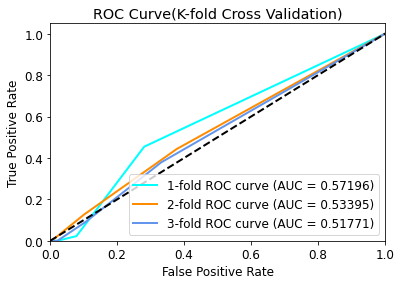

2022-11-25 03:06:08.595724


In [12]:
target="mid";out_type=0
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
            fn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
            tn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])
    
plt.figure()
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 12})
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()
print(datetime.datetime.today())